In [2]:
!pip install pymc3
!pip install GPy

     |████████████████████████████████| 1.0MB 5.7MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633934 sha256=18ece9dee1ea5b4265ae55bddccdaf747d03cabc94663942ff8e466d75d28328
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=8c4caff05c89d71aeba1c5d4815aa873a01dfc50f1636abbc566ce73671aef17
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [3]:
import pymc3 as pm
import GPy as GPy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
from scipy.stats import linregress 
%matplotlib inline

In [4]:
from google.colab import files
uploaded = files.upload()


Saving test.csv to test.csv
Saving train.csv to train.csv


In [5]:
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

**Data Exploration**

In [6]:
#generate the time intervals
time = np.linspace(0,1,100)

In [7]:
df_train.head()

Id         0         1         2  ...        97        98        99  Category
0  120  0.147298 -0.142030  0.091737  ... -0.008333  0.168574  0.123273         0
1  121  0.115710  0.105061  0.038446  ...  0.020398  0.039687  0.217384         0
2  122 -0.548826 -0.466551 -0.650890  ... -0.019942  0.058902  0.053936         0
3  123  0.192618  0.291155 -0.042980  ...  0.190920  0.251743  0.337730         1
4  124  0.075706  0.069045 -0.019818  ...  0.554588  0.471489  0.384229         1

[5 rows x 102 columns]

In [8]:
y=(df_train[df_train.columns[1:-1]])


In [9]:
print(y.shape)
print(df_train.shape)
print(df_test.shape)
print(time.shape)

(75, 100)
(75, 102)
(120, 101)
(100,)


In [10]:
y.head()

0         1         2  ...        97        98        99
0  0.147298 -0.142030  0.091737  ... -0.008333  0.168574  0.123273
1  0.115710  0.105061  0.038446  ...  0.020398  0.039687  0.217384
2 -0.548826 -0.466551 -0.650890  ... -0.019942  0.058902  0.053936
3  0.192618  0.291155 -0.042980  ...  0.190920  0.251743  0.337730
4  0.075706  0.069045 -0.019818  ...  0.554588  0.471489  0.384229

[5 rows x 100 columns]

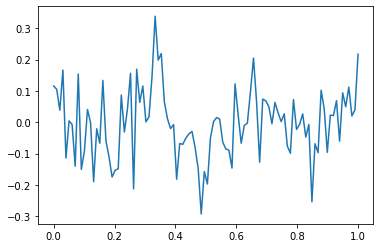

In [11]:
#Look at one example
plt.plot(time,y.iloc[45])

### **`THE GAUSSIAN PROCESSES MODEL`**

Following issues:

Regular errors about "zero values" and NaN values are obtained. 
  
  LinAlgError: 3-th leading minor of the array is not positive definite
  array must not contain infs or NaNs

  Last model was about 50% accurate- need to look at adding a generic term, but need to resolve the LinAlgError issue first


In [60]:

def run_model(x,y):   

  with pm.Model() as model_gp:

    ###  periodic component x  (still a work in progress)
    #n_per = pm.HalfCauchy("n_per", beta=5, testval=1)
    #period  = pm.Normal("period", mu=1, sigma=3)
    #smooth = pm.Gamma("smooth ", alpha=1, beta=1)
    #smooth = pm.HalfCauchy("smooth ", beta=1, testval=0.5)
    #smooth = pm.HalfCauchy("smooth ", beta=1,testval=0.5) #my attempt to fix
    #cov_seasonal = n_per**2 * pm.gp.cov.Periodic(1, period, smooth)
    #cov_seasonal = n_per**2 * pm.gp.cov.Cosine(1, smooth)     
    #gp1 = pm.gp.Marginal(cov_func=cov_seasonal)

    n_per = pm.HalfCauchy("n_per", beta=5, testval=1)
    smooth = pm.HalfCauchy("smooth ", beta=1, testval=0.5)
    cov_seasonal = n_per**2 * pm.gp.cov.Cosine(1,  smooth)     
    gp1 = pm.gp.Marginal(cov_func=cov_seasonal)

    

    ###  linear component x 
    tau = pm.HalfCauchy("tau", beta=2,  testval=1)
    c  = pm.Normal("c", mu=0, sigma=1) 
    #c  = pm.HalfCauchy("C", beta=5, testval=1) #myattempt to fix
    

    cov_linear = tau * pm.gp.cov.Linear(1, c)     
    gp2 = pm.gp.Marginal(cov_func=cov_linear)

    ### gp represents f1 + f2 + f3.
    gp =  gp1 +gp2 #+gp3 

    #### noise model
    sigma = pm.HalfCauchy("sigma", beta=5, testval=0.5)
    f=gp.marginal_likelihood("f", x, y, noise=sigma)

    ####this line calls an optimizer to optimize the marginal likelihood
    mp = pm.find_MAP(include_transformed=True)


    #print("completed find_MAP")
    #we can do  an approximated inference
    #with model_gp:
    #    inference = pm.ADVI()
    #    approx = pm.fit(60000, method=inference)

    
    #posterior_gp = approx.sample(draws=500)
    #print("posterior samples complete")   

    ##
    ###MAKE MODEL PREDICTIONS
    ###
    
    #create new time
    time_new=np.linspace(0,1,100)
    x_new=time_new[:,None]
    
    #COMPLETE PREDICTIONS for periodic and linear terms
    #periodic term
    f1_pred = gp1.predict(x_new, point=mp, given={"gp": gp, "X": x, "y": y, "noise": sigma})
    y1_pred = gp1.predict(x_new, point=mp, given={"gp": gp, "X": x, "y": y, "noise": sigma}, pred_noise=True)

    #linear term
    f2_pred = gp2.predict(x_new, point=mp, given={"gp": gp, "X": x, "y": y, "noise": sigma})
    y2_pred = gp2.predict(x_new, point=mp, given={"gp": gp, "X": x, "y": y, "noise": sigma}, pred_noise=True)

    slope, intercept, r_value, p_value, std_err = linregress(x_new[:,0], f2_pred[0])
    ##all_slopes=all_slopes.append(slope)  #create seperate global np.array
    print("The slope is:",slope)

    #makeplot
    plt.figure()
    plt.plot(x, y, alpha=0.9, label="Observed data", Zorder=1000);
    plt.plot(x_new,f2_pred[0], c='r',zorder=2);
    plt.plot(x_new,f1_pred[0], c='b',zorder=1);
    plt.legend()


    if slope >0:
      return 1
    else: 
      return 0




#Try on the training set

In [16]:
all_slopes=[]

0


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 77.369, ||grad|| = 0.0033641: 100%|██████████| 51/51 [00:00<00:00, 133.96it/s]  


The slope is:
1


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 76.788, ||grad|| = 0.0014578: 100%|██████████| 64/64 [00:00<00:00, 167.97it/s]  


The slope is:
2


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 68.757, ||grad|| = 0.041014: 100%|██████████| 35/35 [00:00<00:00, 202.57it/s]  


The slope is:
3


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 75.405, ||grad|| = 0.0049921: 100%|██████████| 34/34 [00:00<00:00, 226.00it/s]  


The slope is:
4


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 79.924, ||grad|| = 0.029476: 100%|██████████| 46/46 [00:00<00:00, 201.75it/s]  


The slope is:
5


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 68.413, ||grad|| = 0.13696: 100%|██████████| 56/56 [00:00<00:00, 186.22it/s]  


The slope is:
6


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 62.034, ||grad|| = 0.0034209: 100%|██████████| 35/35 [00:00<00:00, 141.42it/s]  


The slope is:
7


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 64.403, ||grad|| = 0.79648: 100%|██████████| 31/31 [00:00<00:00, 137.24it/s]  


The slope is:
8


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 64.478, ||grad|| = 0.046871: 100%|██████████| 36/36 [00:00<00:00, 221.91it/s]  


The slope is:
9


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 95.908, ||grad|| = 0.088574: 100%|██████████| 41/41 [00:00<00:00, 129.88it/s]  


The slope is:
10


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 60.565, ||grad|| = 0.15138: 100%|██████████| 39/39 [00:00<00:00, 223.26it/s]  


The slope is:
11


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 81.488, ||grad|| = 109.03: 100%|██████████| 76/76 [00:00<00:00, 179.31it/s]  


The slope is:
12


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 80.206, ||grad|| = 0.011819: 100%|██████████| 51/51 [00:00<00:00, 170.40it/s]  


The slope is:
13


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 74.845, ||grad|| = 0.0049147: 100%|██████████| 59/59 [00:00<00:00, 175.47it/s]  


The slope is:
14


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 74.092, ||grad|| = 0.001505: 100%|██████████| 69/69 [00:00<00:00, 144.42it/s]  


The slope is:
15


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 66.76, ||grad|| = 0.015272: 100%|██████████| 44/44 [00:00<00:00, 172.11it/s]  


The slope is:
16


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 69.419, ||grad|| = 0.00029802: 100%|██████████| 62/62 [00:00<00:00, 130.98it/s]  


The slope is:
17


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 62.668, ||grad|| = 0.0099159: 100%|██████████| 55/55 [00:00<00:00, 131.33it/s]  


The slope is:
18


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 69.284, ||grad|| = 0.27867: 100%|██████████| 51/51 [00:00<00:00, 213.03it/s]  


The slope is:
19


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 63.715, ||grad|| = 0.032399: 100%|██████████| 40/40 [00:00<00:00, 135.93it/s]  


The slope is:
20


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 65.957, ||grad|| = 0.85802: 100%|██████████| 47/47 [00:00<00:00, 205.35it/s]  


The slope is:
21


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 68.471, ||grad|| = 0.71087: 100%|██████████| 41/41 [00:00<00:00, 144.03it/s]  


The slope is:
22


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 82.225, ||grad|| = 0.0068027: 100%|██████████| 44/44 [00:00<00:00, 175.44it/s]  


The slope is:
23


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 46.074, ||grad|| = 0.017526: 100%|██████████| 43/43 [00:00<00:00, 143.24it/s]  


The slope is:
24


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 55.861, ||grad|| = 0.0022544: 100%|██████████| 33/33 [00:00<00:00, 195.86it/s]  


The slope is:
25


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 72.882, ||grad|| = 0.0048017: 100%|██████████| 59/59 [00:00<00:00, 181.28it/s]  


The slope is:
26


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 81.18, ||grad|| = 0.0023281: 100%|██████████| 56/56 [00:00<00:00, 235.75it/s]  


The slope is:
27


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 79.237, ||grad|| = 0.092984: 100%|██████████| 38/38 [00:00<00:00, 232.35it/s]  


The slope is:
28


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 90.89, ||grad|| = 0.0037418: 100%|██████████| 62/62 [00:00<00:00, 134.85it/s]  


The slope is:
29


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 82.711, ||grad|| = 0.10525: 100%|██████████| 48/48 [00:00<00:00, 173.79it/s]  


The slope is:
30


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 79.037, ||grad|| = 1.4914: 100%|██████████| 38/38 [00:00<00:00, 232.34it/s]  


The slope is:
31


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 50.539, ||grad|| = 0.09276: 100%|██████████| 28/28 [00:00<00:00, 136.53it/s]  


The slope is:
32


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 61.145, ||grad|| = 0.00026029: 100%|██████████| 43/43 [00:00<00:00, 145.75it/s]  


The slope is:
33


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 67.972, ||grad|| = 0.038447: 100%|██████████| 39/39 [00:00<00:00, 137.68it/s]  


The slope is:
34


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 75.364, ||grad|| = 0.048964: 100%|██████████| 50/50 [00:00<00:00, 180.87it/s]  


The slope is:
35


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 66.887, ||grad|| = 0.00020876: 100%|██████████| 42/42 [00:00<00:00, 151.65it/s]  


The slope is:
36


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 56.816, ||grad|| = 0.13978: 100%|██████████| 36/36 [00:00<00:00, 144.56it/s]  


The slope is:
37


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 62.9, ||grad|| = 0.039066: 100%|██████████| 36/36 [00:00<00:00, 133.19it/s]  


The slope is:
38


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 91.995, ||grad|| = 0.0066658: 100%|██████████| 94/94 [00:00<00:00, 176.28it/s]  


The slope is:
39


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 77.232, ||grad|| = 0.0011126: 100%|██████████| 43/43 [00:00<00:00, 167.71it/s]  


The slope is:
40


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 74.328, ||grad|| = 0.00080508: 100%|██████████| 44/44 [00:00<00:00, 233.74it/s]  


The slope is:
41


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 81.522, ||grad|| = 0.46571: 100%|██████████| 75/75 [00:00<00:00, 173.90it/s]  


The slope is:
42


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 57.716, ||grad|| = 0.32189: 100%|██████████| 25/25 [00:00<00:00, 226.95it/s]  


The slope is:
43


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 83.3, ||grad|| = 0.00085418: 100%|██████████| 84/84 [00:00<00:00, 193.38it/s]  


The slope is:
44


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 65.214, ||grad|| = 0.15102: 100%|██████████| 60/60 [00:00<00:00, 156.44it/s]  


The slope is:
45


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 50.269, ||grad|| = 0.35712: 100%|██████████| 39/39 [00:00<00:00, 143.02it/s]  


The slope is:
46


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 82.363, ||grad|| = 0.0021566: 100%|██████████| 47/47 [00:00<00:00, 159.23it/s]  


The slope is:
47


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 72.133, ||grad|| = 0.0010824: 100%|██████████| 42/42 [00:00<00:00, 132.68it/s]  


The slope is:
48


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 51.179, ||grad|| = 0.0025761: 100%|██████████| 44/44 [00:00<00:00, 238.44it/s]  


The slope is:
49


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 68.277, ||grad|| = 0.47852: 100%|██████████| 47/47 [00:00<00:00, 139.24it/s]  


The slope is:
50


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 71.365, ||grad|| = 0.17534: 100%|██████████| 35/35 [00:00<00:00, 177.62it/s]  


The slope is:
51


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 78.219, ||grad|| = 5.0951: 100%|██████████| 31/31 [00:00<00:00, 204.24it/s]  


The slope is:
52


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 62.949, ||grad|| = 0.0023142: 100%|██████████| 44/44 [00:00<00:00, 179.45it/s]  


The slope is:
53


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 63.746, ||grad|| = 0.66166: 100%|██████████| 39/39 [00:00<00:00, 142.97it/s]  


The slope is:
54


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 69.303, ||grad|| = 0.027838: 100%|██████████| 60/60 [00:00<00:00, 206.98it/s]  


The slope is:
55


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 79.733, ||grad|| = 0.0036958: 100%|██████████| 60/60 [00:00<00:00, 163.74it/s]  


The slope is:
56


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 68.591, ||grad|| = 0.036786: 100%|██████████| 60/60 [00:00<00:00, 136.17it/s]  


The slope is:
57


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 54.405, ||grad|| = 0.004726: 100%|██████████| 76/76 [00:00<00:00, 185.09it/s]  


The slope is:
58


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 92.212, ||grad|| = 2.7127: 100%|██████████| 29/29 [00:00<00:00, 157.57it/s]  


The slope is:
59


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 74.814, ||grad|| = 0.0014224: 100%|██████████| 45/45 [00:00<00:00, 231.39it/s]  


The slope is:
60


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 73.689, ||grad|| = 4.331: 100%|██████████| 67/67 [00:00<00:00, 166.23it/s]  


The slope is:
61


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 68.795, ||grad|| = 0.11479: 100%|██████████| 40/40 [00:00<00:00, 184.98it/s]  


The slope is:
62


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 56.353, ||grad|| = 4.1212e-05: 100%|██████████| 32/32 [00:00<00:00, 252.83it/s]  


The slope is:
63


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 80.567, ||grad|| = 0.023388: 100%|██████████| 34/34 [00:00<00:00, 251.46it/s]  


The slope is:
64


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 66.692, ||grad|| = 0.0030187: 100%|██████████| 48/48 [00:00<00:00, 176.85it/s]  


The slope is:
65


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 75.966, ||grad|| = 0.19756: 100%|██████████| 48/48 [00:00<00:00, 140.12it/s]  


The slope is:
66


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 78.426, ||grad|| = 0.058809: 100%|██████████| 70/70 [00:00<00:00, 146.13it/s]  


The slope is:
67


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 76.208, ||grad|| = 0.0066306: 100%|██████████| 53/53 [00:00<00:00, 201.75it/s]  


The slope is:
68


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 76.897, ||grad|| = 0.018703: 100%|██████████| 58/58 [00:00<00:00, 152.89it/s]  


The slope is:
69


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 69.805, ||grad|| = 0.38305: 100%|██████████| 50/50 [00:00<00:00, 251.96it/s]  


The slope is:
70


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 60.088, ||grad|| = 0.017074: 100%|██████████| 63/63 [00:00<00:00, 169.81it/s]  


The slope is:
71


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 74.183, ||grad|| = 0.0039552: 100%|██████████| 63/63 [00:00<00:00, 214.68it/s]  


The slope is:
72


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 72.517, ||grad|| = 0.00498: 100%|██████████| 45/45 [00:00<00:00, 247.56it/s]  


The slope is:
73


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 64.239, ||grad|| = 0.013146: 100%|██████████| 69/69 [00:00<00:00, 172.57it/s]  


The slope is:
74


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 78.197, ||grad|| = 0.38769: 100%|██████████| 30/30 [00:00<00:00, 169.77it/s]  


The slope is:


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


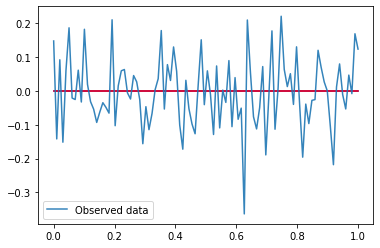

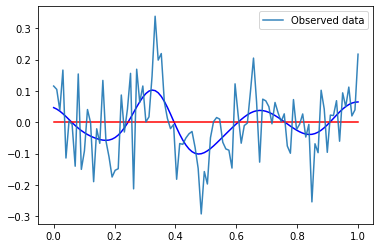

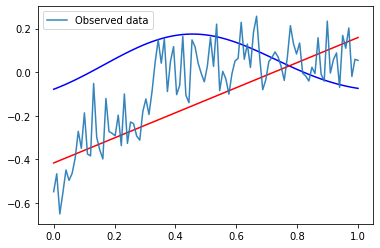

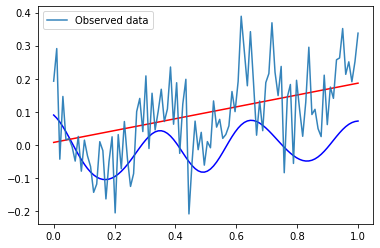

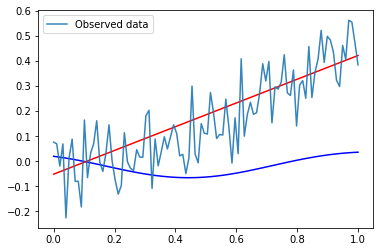

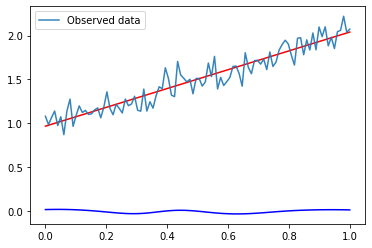

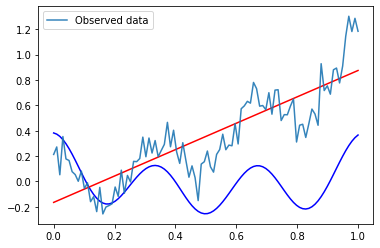

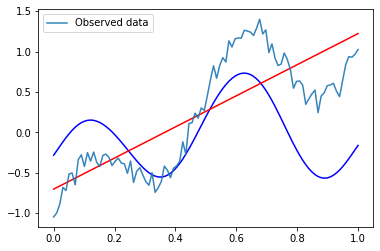

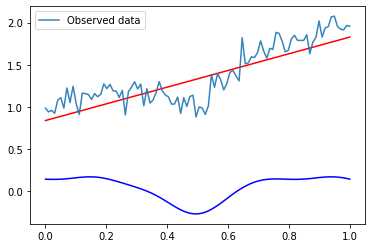

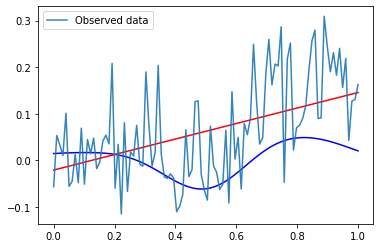

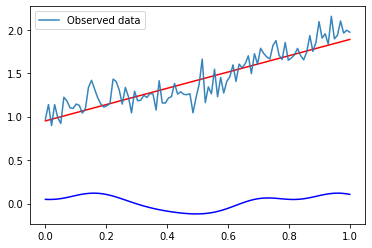

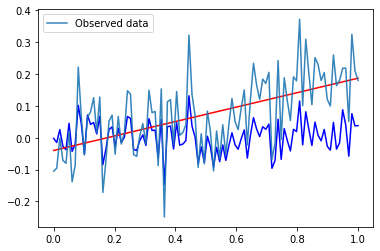

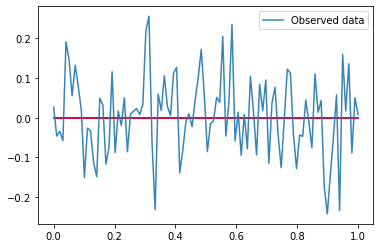

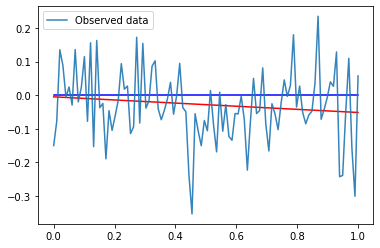

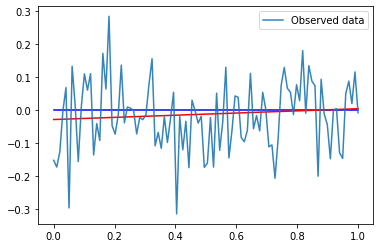

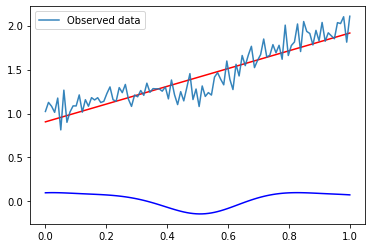

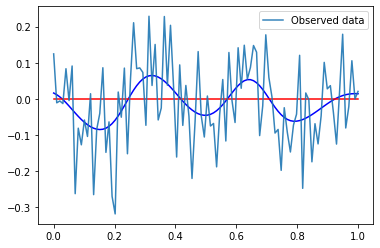

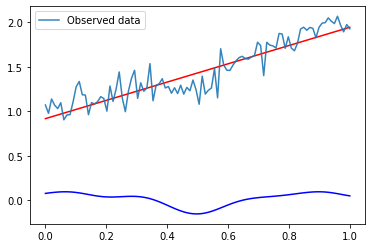

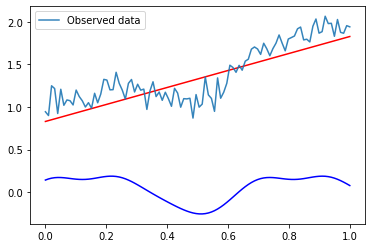

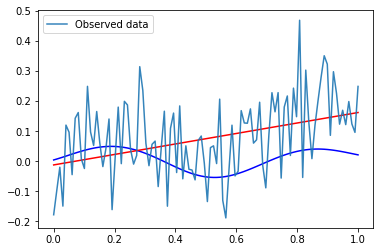

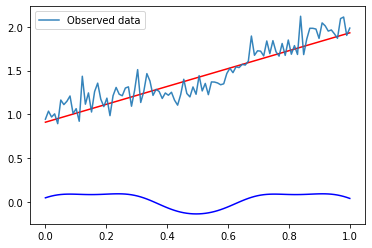

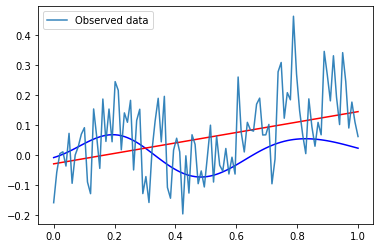

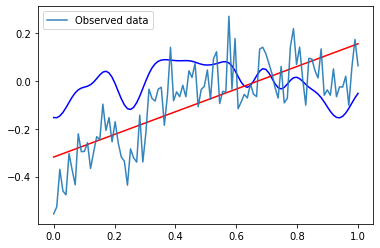

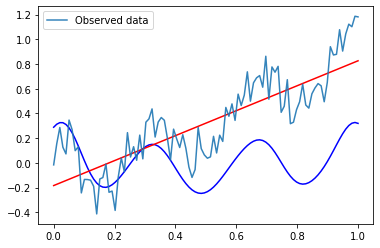

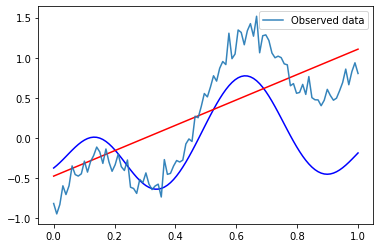

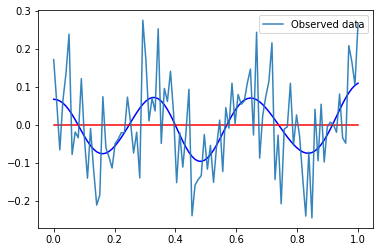

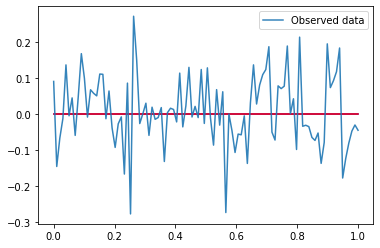

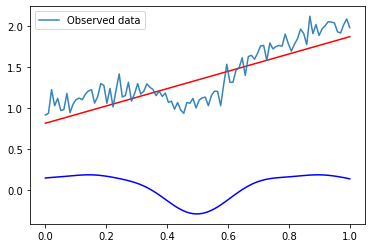

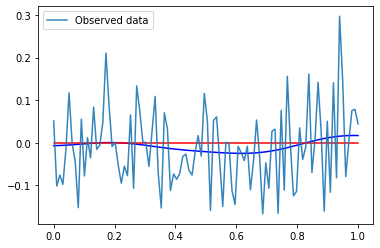

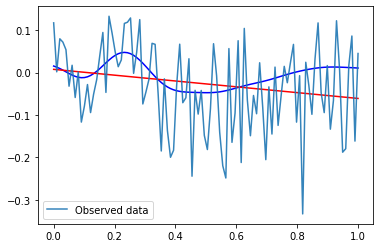

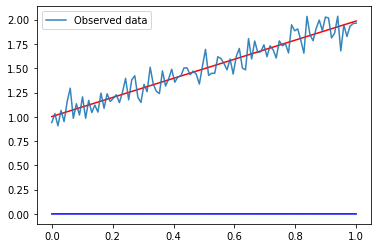

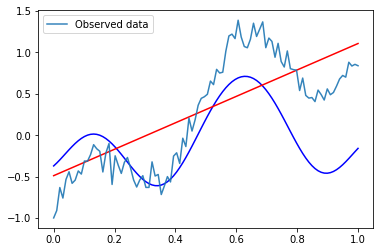

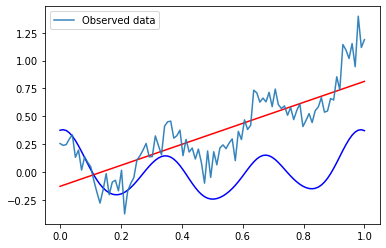

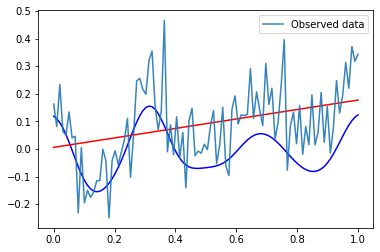

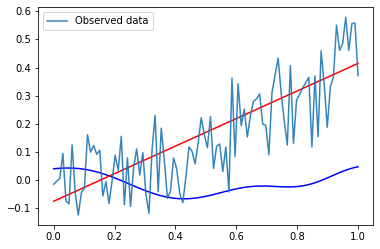

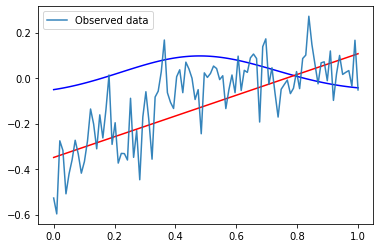

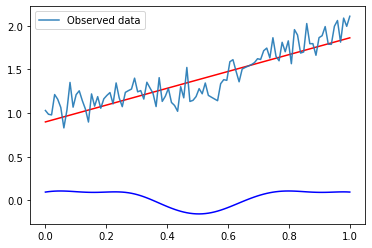

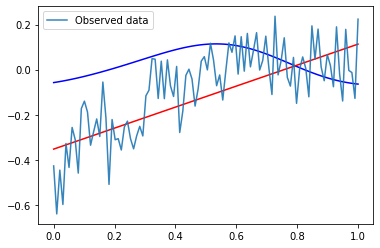

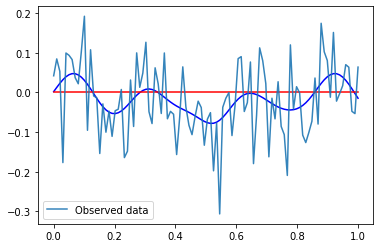

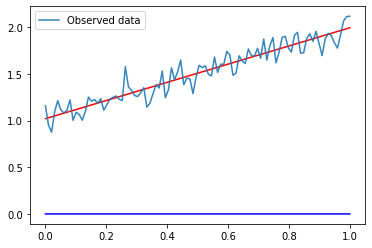

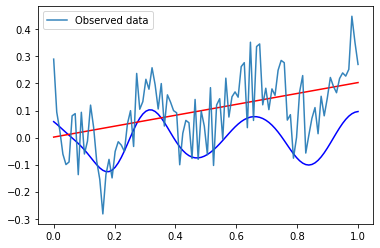

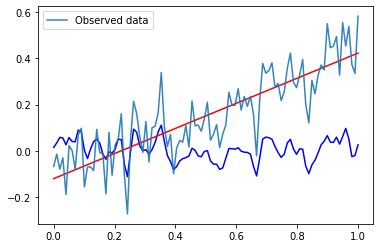

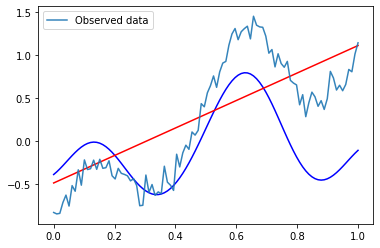

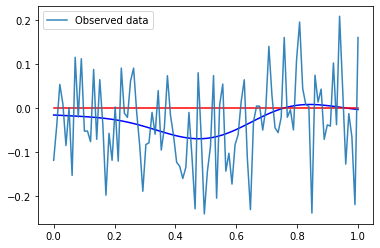

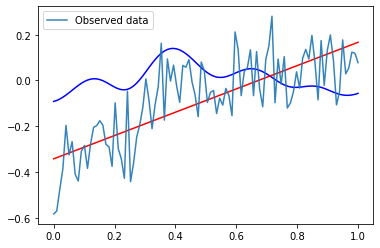

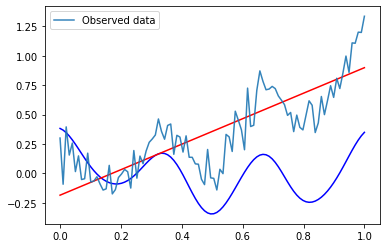

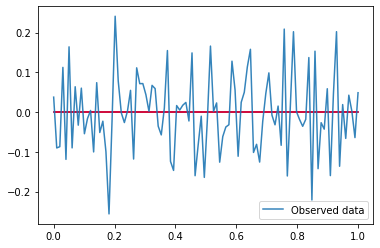

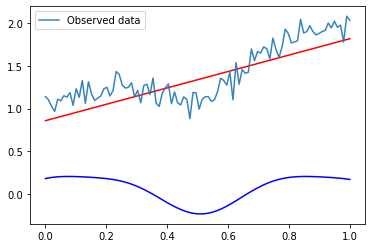

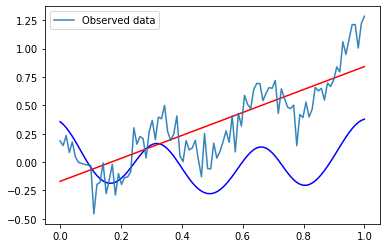

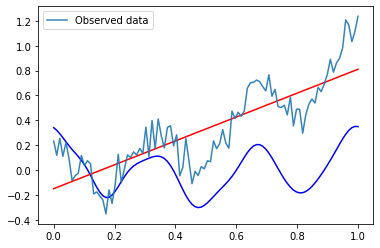

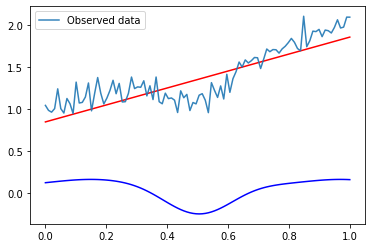

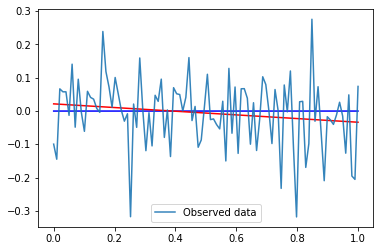

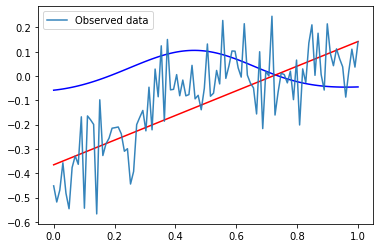

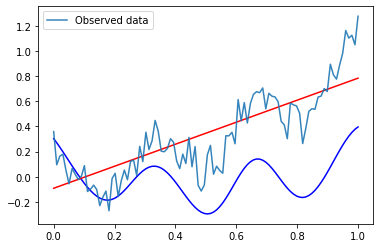

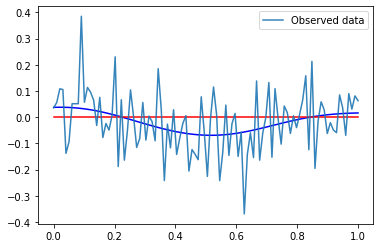

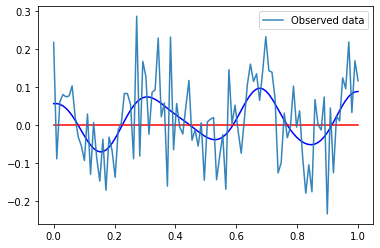

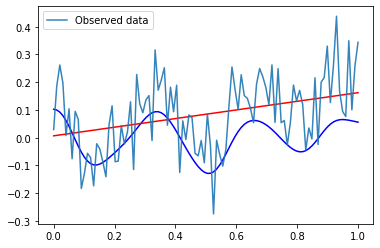

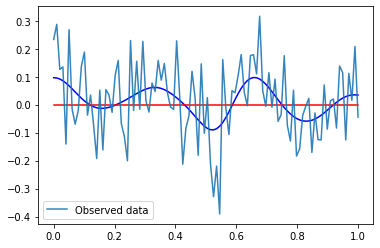

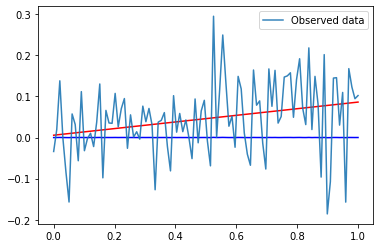

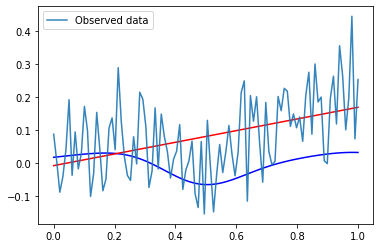

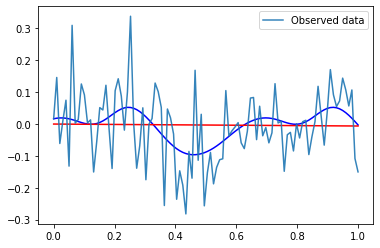

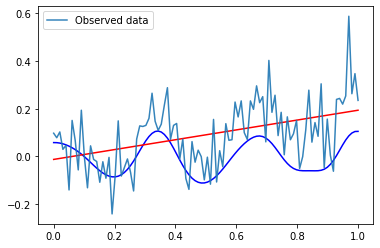

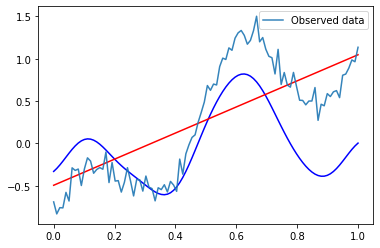

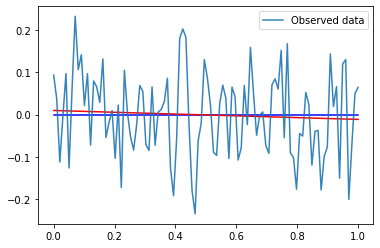

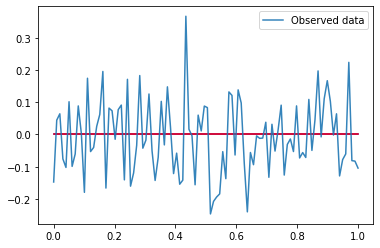

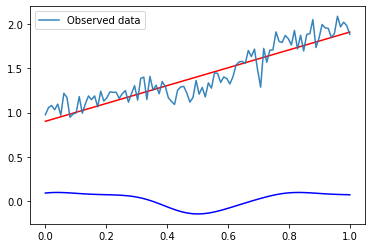

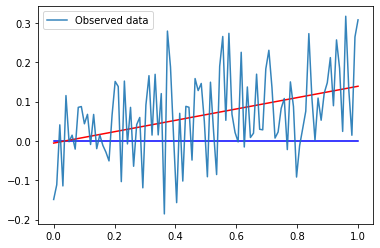

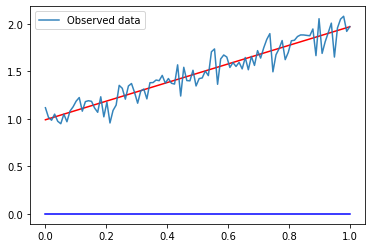

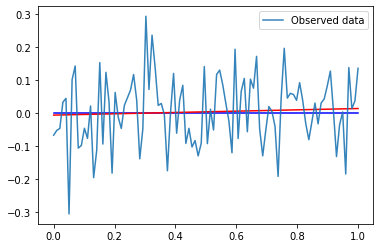

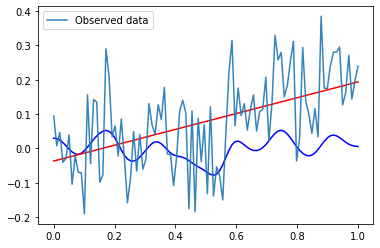

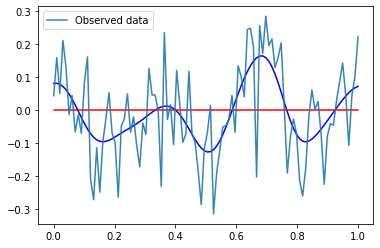

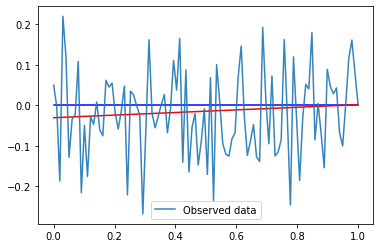

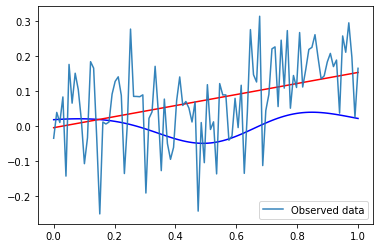

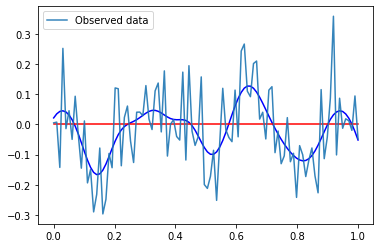

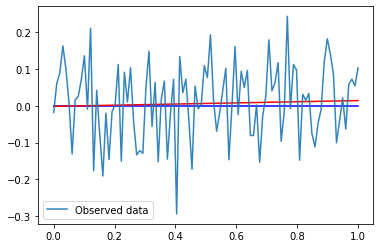

In [28]:

Decision = pd.DataFrame(columns=['Id','Category'])
for r in range(df_train.shape[0]): #might need to fix this line
    id_row = df_train.iloc[r,0]
    print(r)
    y = df_train.iloc[r,1:-1].values
    #print(y.shape)
    #print(time.shape)
    X=time[:, None]

    decision = run_model(X,y)
    Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
    #print(Decision)
    Decision.to_csv("decision.csv",  index=False)





In [39]:
y_actual=df_train.iloc[:,-1]
y_predicted=Decision['Category']
print(y_actual.shape)
print(y_predicted.shape)


#Training Set Accuracy

correct=np.sum(y_actual==y_predicted)
accuracy=correct/len(y_actual)
print(accuracy)

(75,)
(75,)
0.52


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
def make_classification(df,x,a):
  #note a=-1 for training set and 0 for test set

  Decision = pd.DataFrame(columns=['Id','Category'])
  for r in range(df.shape[0]): #might need to fix this line
      id_row = df.iloc[r,0]
      print(r)

      if a==-1:
        y = df.iloc[r,1:-1].values
      else:
        y = df.iloc[r,1:].values
    
      print(y.shape)
      print(time.shape)
      X=x[:, None]

      decision = run_model(X,y)
      Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
      #print(Decision)

     
  return Decision



0
(100,)
(100,)


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 75.243, ||grad|| = 0.43796: 100%|██████████| 35/35 [00:00<00:00, 145.93it/s]  


The slope is: 1.0067708712901973
1
(100,)
(100,)


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 81.646, ||grad|| = 2.6658: 100%|██████████| 40/40 [00:00<00:00, 170.86it/s]  


The slope is: 0.21211241541034526
2
(100,)
(100,)


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 82.952, ||grad|| = 0.006093: 100%|██████████| 44/44 [00:00<00:00, 277.65it/s]  


The slope is: 0.14011357595016896
3
(100,)
(100,)


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 82.881, ||grad|| = 0.12898: 100%|██████████| 60/60 [00:00<00:00, 208.07it/s]  


The slope is: 0.009053751203296802
4
(100,)
(100,)


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 58.526, ||grad|| = 0.00017903: 100%|██████████| 42/42 [00:00<00:00, 264.91it/s]  


The slope is: 0.9662607226660939
5
(100,)
(100,)


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 20.559, ||grad|| = 0.00025233: 100%|██████████| 43/43 [00:00<00:00, 145.24it/s]  


The slope is: 1.0441547191621376
6
(100,)
(100,)


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 72.064, ||grad|| = 0.0030575: 100%|██████████| 59/59 [00:00<00:00, 215.33it/s]  


The slope is: 0.47831212136356344
7
(100,)
(100,)


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 84.074, ||grad|| = 0.11934: 100%|██████████| 78/78 [00:00<00:00, 158.39it/s]  


The slope is: 0.14203507062187307
8
(100,)
(100,)


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 72.52, ||grad|| = 0.0046879: 100%|██████████| 57/57 [00:00<00:00, 174.74it/s]  


The slope is: 0.13352604453130634
9
(100,)
(100,)


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 28.575, ||grad|| = 0.67898: 100%|██████████| 57/57 [00:00<00:00, 229.05it/s]  


The slope is: 2.397965038216385
10
(100,)
(100,)


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 69.981, ||grad|| = 0.069984: 100%|██████████| 40/40 [00:00<00:00, 255.02it/s]  


The slope is: 0.9309671912812413
11
(100,)
(100,)


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 71.186, ||grad|| = 0.019851: 100%|██████████| 41/41 [00:00<00:00, 273.96it/s]  


The slope is: 0.4972391797989349
12
(100,)
(100,)


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 6.7164, ||grad|| = 12.534: 100%|██████████| 15/15 [00:00<00:00, 145.34it/s]  


LinAlgError: ignored

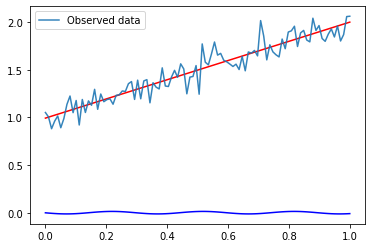

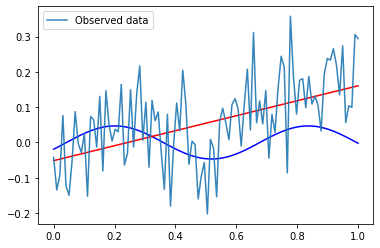

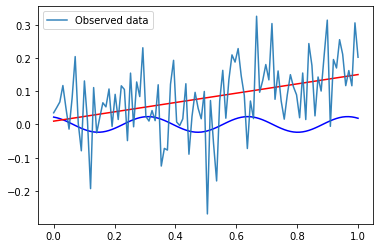

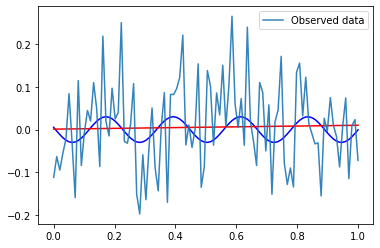

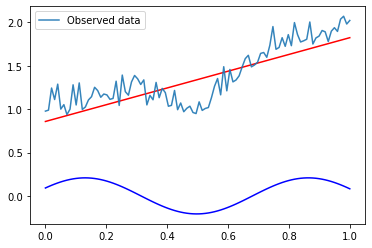

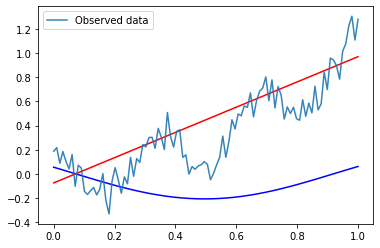

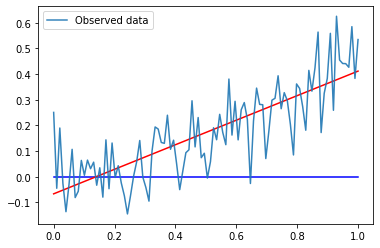

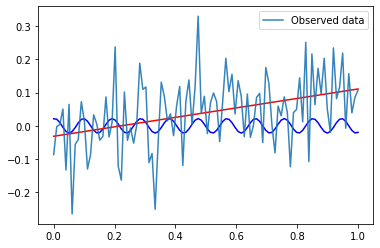

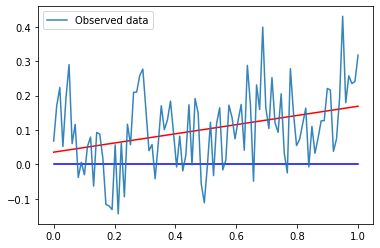

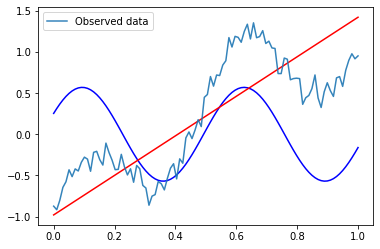

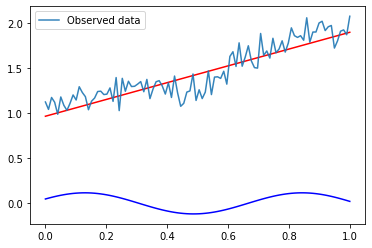

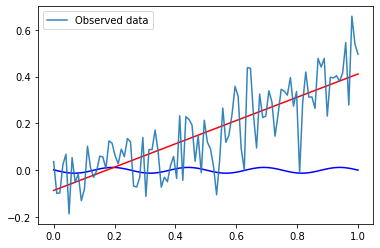

In [61]:
Decision=make_classification(df_test,time,0)

In [ ]:
Decision.to_csv("decision.csv",  index=False)
files.download('decision.csv')

In [ ]:
def accuracy_estimate(dfactual,dfpredicted):
     y_actual=dfactual.iloc[:,-1]
     y_predicted=dfpredicted['Category']
     #print(y_actual.shape)
     #print(y_predicted.shape)

      #Accuracy
      correct=np.sum(y_actual==y_predicted)
      accuracy=correct/len(y_actual)
      print("The accuracy is",accuracy)
return

## Ideas to improve baseline

1. Adding another non-linear basis function components (e.g., $tanh(w0+w1x)$) and seeing if you can better split the seasonal and non-seasonal component.
2. In the second example, the sin/cos basis function fits the nonlinear function, but it is clear that the obtained mean function is non-periodic. By definition a function is periodic in the interval [0,1] if you see at least one full cycle (e.g. $cos(\pi x)$ is not peridic in [0,1] but $cos(2 \pi x)$ is). So you could try to verify if the function is periodic or not. In case it is periodic you can use "non_periodic_prediction" for checking if the function is increasing or not. Instead, if the function is not periodic that you could use  "all_prediction" for checking if the function is increasing or not. How can you test if a function is periodic or not given your basis functions in H ?
3. The baseline model computes the derivative of the non-seasonal component and checks if the derivative is non-negative for all $x\in[0,1]$ as a way to assess if sales are increasing. Could an analytical derivative work better in the above case?
4. You could try to use GPs
5. Is the decision criterion "posterior_probability_deriviative_is_positive>0.95" the best way to make decisions? Maybe you would do better if you take into account the way weighted accuracy is defined for this competition.